In [2]:
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point
import time
import matplotlib.pyplot as plt
import seaborn as sns
import geodatasets
import numpy as np


---

## Extracting station location from PDF

In [3]:
data = [
    {"river": "Thur", "city": "Hohentannen"}, # Had to modify from Halden, Thur, since there are two Halden
    {"river": "Rhein", "city": "Diepoldsau, Rietbrücke"},
    {"river": "Emme", "city": "Wiler, Biberist"},
    {"river": "Aare", "city": "Hagneck"},
    {"river": "Kleine Emme", "city": "Emmen"},
    {"river": "Linth", "city": "Mollis, Kupfernsteg"},
    {"river": "Reuss", "city": "Altdorf"}, # Had to modify from Seedorf, since there are two Seedorfs
    {"river": "Aare", "city": "Brienzwiler"},
    {"river": "Lütschine", "city": "Bönigen"},
    {"river": "Massa", "city": "Blatten"},
    {"river": "Rhône", "city": "Chessel"}, # Had to modify from Porte du Scex because there was a geocoding issue
    {"river": "Arve", "city": "Genf, Bout du Monde"},
    {"river": "Maggia", "city": "Solduno"},
    {"river": "Ticino", "city": "Bellinzona"}
]

df = pd.DataFrame(data)

print(df)


          river                    city
0          Thur             Hohentannen
1         Rhein  Diepoldsau, Rietbrücke
2          Emme         Wiler, Biberist
3          Aare                 Hagneck
4   Kleine Emme                   Emmen
5         Linth     Mollis, Kupfernsteg
6         Reuss                 Altdorf
7          Aare             Brienzwiler
8     Lütschine                 Bönigen
9         Massa                 Blatten
10        Rhône                 Chessel
11         Arve     Genf, Bout du Monde
12       Maggia                 Solduno
13       Ticino              Bellinzona


In [4]:
geolocator = Nominatim(user_agent="river_monitoring_locations")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)


# Function to extract city name for geocoding
def extract_main_city(city_str):
    # For complex names, extract the first part which is usually the main city
    if " " in city_str:
        # Special cases
        if "," in city_str:
            return city_str.split(",")[0]
        # For cities with specific locations, take the first word
        else:
            return city_str.split(" ")[0]
    return city_str


# Add the country context for better geocoding results (most locations are in Switzerland)
def geocode_with_country(city):
    main_city = extract_main_city(city)
    # Add ", Switzerland" to improve geocoding accuracy
    try:
        location = geocode(f"{main_city}, Switzerland")
        if location:
            return (location.latitude, location.longitude)
        # Try without country if not found
        location = geocode(main_city)
        if location:
            return (location.latitude, location.longitude)
    except Exception as e:
        print(f"Error geocoding {city}: {e}")
    return (None, None)


# Apply geocoding to get coordinates (with progress tracking)
print("Starting geocoding...")
coordinates = []
total = len(df)

for i, city in enumerate(df["city"]):
    print(f"Geocoding {i + 1}/{total}: {city}")
    lat, lon = geocode_with_country(city)
    coordinates.append((lat, lon))
    # Small delay to be nice to the geocoding service
    time.sleep(1)

# Add coordinates to the dataframe
df["latitude"], df["longitude"] = zip(*coordinates)

# Create geometry from coordinates
geometry = [
    Point(lon, lat) if lon and lat else None
    for lat, lon in zip(df["latitude"], df["longitude"])
]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Handle any missing geometries
print(
    f"Successfully geocoded: {gdf.geometry.notnull().sum()} out of {len(gdf)} locations"
)
print(f"Failed to geocode: {gdf.geometry.isnull().sum()} locations")

# Show the first few entries
print(gdf.head(20))

Starting geocoding...
Geocoding 1/14: Hohentannen
Geocoding 2/14: Diepoldsau, Rietbrücke
Geocoding 3/14: Wiler, Biberist
Geocoding 4/14: Hagneck
Geocoding 5/14: Emmen
Geocoding 6/14: Mollis, Kupfernsteg
Geocoding 7/14: Altdorf
Geocoding 8/14: Brienzwiler
Geocoding 9/14: Bönigen
Geocoding 10/14: Blatten
Geocoding 11/14: Chessel
Geocoding 12/14: Genf, Bout du Monde
Geocoding 13/14: Solduno
Geocoding 14/14: Bellinzona
Successfully geocoded: 14 out of 14 locations
Failed to geocode: 0 locations
          river                    city   latitude  longitude  \
0          Thur             Hohentannen  47.508395   9.224607   
1         Rhein  Diepoldsau, Rietbrücke  47.385951   9.655604   
2          Emme         Wiler, Biberist  47.151251   7.558362   
3          Aare                 Hagneck  47.056933   7.187050   
4   Kleine Emme                   Emmen  47.075243   8.283946   
5         Linth     Mollis, Kupfernsteg  47.093360   9.074411   
6         Reuss                 Altdorf  46.88207

river                                Thur
city                          Hohentannen
latitude                        47.508395
longitude                        9.224607
geometry     POINT (9.2246069 47.5083945)
Name: 0, dtype: object
river                               Rhein
city               Diepoldsau, Rietbrücke
latitude                        47.385951
longitude                        9.655604
geometry     POINT (9.6556042 47.3859513)
Name: 1, dtype: object
river                                Emme
city                      Wiler, Biberist
latitude                        47.151251
longitude                        7.558362
geometry     POINT (7.5583621 47.1512512)
Name: 2, dtype: object
river                                Aare
city                              Hagneck
latitude                        47.056933
longitude                         7.18705
geometry     POINT (7.1870499 47.0569331)
Name: 3, dtype: object
river                         Kleine Emme
city                      

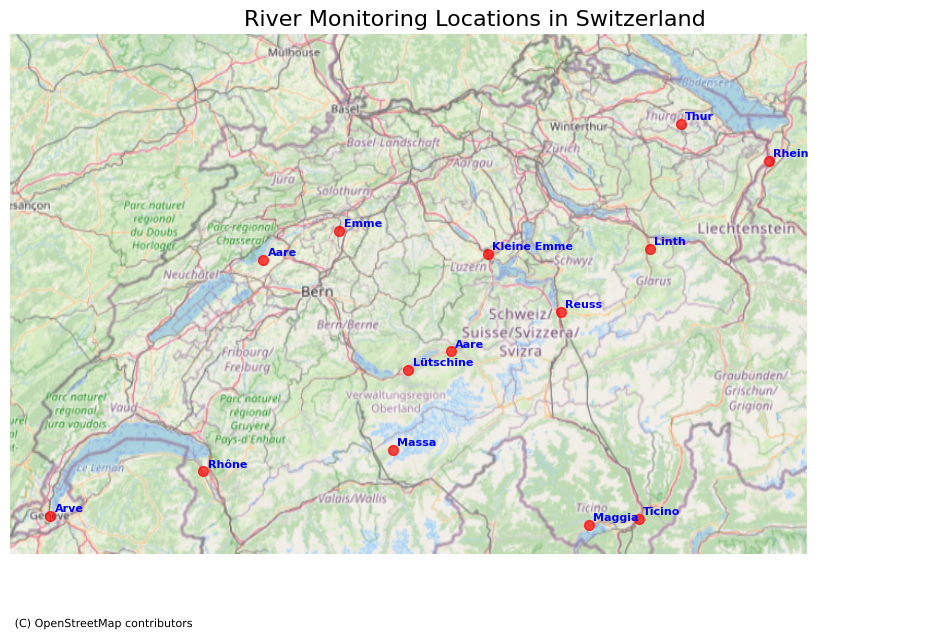

Geocoded data saved to shapefile.


In [5]:
import contextily as ctx

# Setup the map plot
fig, ax = plt.subplots(figsize=(12, 10))

# Switzerland bounding box (more accurate than your original)
xmin, ymin, xmax, ymax = 5.95, 45.82, 10.49, 47.81

# Create a simple dataframe with Switzerland bounds to use as a base
switzerland_box = gpd.GeoDataFrame(
    {"geometry": [Point(xmin, ymin).buffer(0.01), Point(xmax, ymax).buffer(0.01)]},
    crs="EPSG:4326",
)
switzerland_bounds = switzerland_box.total_bounds

# Filter out any points with missing geometry
gdf_clean = gdf[gdf.geometry.notnull()]

# Plot the points
gdf_clean.plot(ax=ax, color="red", markersize=50, alpha=0.7)

# Add basemap
ctx.add_basemap(
    ax, crs=gdf_clean.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik
)

# Set extent to Switzerland
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Add title and remove axis labels
plt.title("River Monitoring Locations in Switzerland", fontsize=16)
ax.set_axis_off()

# Add river names as labels
for idx, row in gdf_clean.iterrows():

    print(row)
    plt.annotate(
        row["river"],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=8,
        color="blue",
        fontweight="bold",
    )

# Save the map
plt.savefig("switzerland_river_monitoring.png", dpi=300, bbox_inches="tight")
plt.show()

# Save the geocoded data to shapefile
path_to_data_folder = "/Users/cooper/Desktop/CAMELS-CH/data/turbidity"

gdf.to_file(f"{path_to_data_folder}/river_monitoring_locations.shp")
print("Geocoded data saved to shapefile.")

In [6]:
gdf_clean.head(20)

,river,city,latitude,longitude,geometry
0,Thur,Hohentannen,47.508395,9.224607,POINT (9.22461 47.50839)
1,Rhein,"Diepoldsau, Rietbrücke",47.385951,9.655604,POINT (9.6556 47.38595)
2,Emme,"Wiler, Biberist",47.151251,7.558362,POINT (7.55836 47.15125)
3,Aare,Hagneck,47.056933,7.187050,POINT (7.18705 47.05693)
4,Kleine Emme,Emmen,47.075243,8.283946,POINT (8.28395 47.07524)
5,Linth,"Mollis, Kupfernsteg",47.093360,9.074411,POINT (9.07441 47.09336)
6,Reuss,Altdorf,46.882073,8.641392,POINT (8.64139 46.88207)
7,Aare,Brienzwiler,46.750119,8.102113,POINT (8.10211 46.75012)
8,Lütschine,Bönigen,46.688734,7.894928,POINT (7.89493 46.68873)
9,Massa,Blatten,46.420581,7.819293,POINT (7.81929 46.42058)


## Find corresponding basins in CAMELS-CH dataset

In [7]:
path_to_gauging_stations = "/Users/cooper/Desktop/CAMELS-CH/data/catchment_delineations/CAMELS_CH_gauging_stations.shp"

gauging_stations = gpd.read_file(path_to_gauging_stations)
print(gauging_stations.head(20))

    gauge_id     ID6       gauge_name           water_body    type country  \
0     2004.0  MuSMur           Murten            Murtensee    lake      CH   
1     2007.0  LdJLeP          Le_Pont          Lac_de_Joux    lake      CH   
2     2009.0  RhoPor    Porte_du_Scex                Rhône  stream      CH   
3     2011.0  RhoSio             Sion                Rhône  stream      CH   
4     2014.0  ZuSSch       Schmerikon  Zürichsee_(Obersee)    lake      CH   
5     2016.0  AarBru            Brugg                 Aare  stream      CH   
6     2017.0  ZuSZug              Zug             Zugersee    lake      CH   
7     2018.0  ReuMel        Mellingen                Reuss  stream      CH   
8     2019.0  AarBri      Brienzwiler                 Aare  stream      CH   
9     2020.0  TicBel       Bellinzona               Ticino  stream      CH   
10    2021.0  LdLPon      Ponte_Tresa       Lago_di_Lugano    lake      CH   
11    2022.0  LaMLoc          Locarno        Lago_Maggiore    la

In [8]:
import re


def clean_name(name):
    if not isinstance(name, str):
        return str(name).lower()
    # Remove special characters and convert to lowercase
    cleaned = re.sub(r"[^a-zA-Z0-9]", "", name.lower())
    return cleaned


def calculate_distance_meters(point1, point2):
    # Convert to a temporary CRS for accurate distance measurement
    temp_crs = "EPSG:3857"  # Web Mercator
    p1_temp = gpd.GeoSeries([point1], crs="EPSG:4326").to_crs(temp_crs)
    p2_temp = gpd.GeoSeries([point2], crs="EPSG:4326").to_crs(temp_crs)
    return p1_temp.distance(p2_temp)[0]


In [ ]:
gauging_stations_wgs84 = gauging_stations.copy()
if gauging_stations_wgs84.crs != "EPSG:4326":
    gauging_stations_wgs84 = gauging_stations_wgs84.to_crs("EPSG:4326")

# Save the reprojected gauging stations
gauging_stations_wgs84.to_file(
    f"{path_to_data_folder}/gauging_stations_wgs84.shp"
)

gdf_clean = gdf[gdf.geometry.notnull()].copy()

gdf_wgs84 = gdf_clean.copy()
if gdf_wgs84.crs != "EPSG:4326":
    gdf_wgs84 = gdf_wgs84.to_crs("EPSG:4326")

gdf_wgs84["clean_river"] = gdf_wgs84["river"].apply(clean_name)
gauging_stations_wgs84["clean_water_body"] = gauging_stations_wgs84["water_body"].apply(
    clean_name
)




In [28]:
gdf_clean

,river,city,latitude,longitude,geometry
0,Thur,Hohentannen,47.508395,9.224607,POINT (9.22461 47.50839)
1,Rhein,"Diepoldsau, Rietbrücke",47.385951,9.655604,POINT (9.6556 47.38595)
2,Emme,"Wiler, Biberist",47.151251,7.558362,POINT (7.55836 47.15125)
3,Aare,Hagneck,47.056933,7.187050,POINT (7.18705 47.05693)
4,Kleine Emme,Emmen,47.075243,8.283946,POINT (8.28395 47.07524)
5,Linth,"Mollis, Kupfernsteg",47.093360,9.074411,POINT (9.07441 47.09336)
6,Reuss,Altdorf,46.882073,8.641392,POINT (8.64139 46.88207)
7,Aare,Brienzwiler,46.750119,8.102113,POINT (8.10211 46.75012)
8,Lütschine,Bönigen,46.688734,7.894928,POINT (7.89493 46.68873)
9,Massa,Blatten,46.420581,7.819293,POINT (7.81929 46.42058)


In [10]:
match_results = []

# For each turbidity station, find matching gauging station
for idx, turb_station in gdf_wgs84.iterrows():
    # Filter gauging stations by matching river name
    matching_stations = gauging_stations_wgs84[
        gauging_stations_wgs84['clean_water_body'] == turb_station['clean_river']
    ]
    
    if not matching_stations.empty:
        # Calculate distances to all matching stations (in meters)
        distances = matching_stations.geometry.apply(
            lambda geom: calculate_distance_meters(turb_station.geometry, geom)
        )
        
        # Find closest station within 1km (1000m)
        min_dist_idx = distances.idxmin()
        min_dist = distances[min_dist_idx]
        
        if min_dist <= 5000:  # 5km threshold
            closest_station = gauging_stations_wgs84.loc[min_dist_idx]
            
            # Store the match
            match_results.append({
                'turbidity_river': turb_station['river'],
                'turbidity_city': turb_station['city'],
                'turbidity_geometry': turb_station.geometry,
                'gauge_id': closest_station['gauge_id'],
                'gauge_name': closest_station['gauge_name'],
                'water_body': closest_station['water_body'],
                'gauge_geometry': closest_station.geometry,
                'distance_m': min_dist
            })
            print(f"Match found: {turb_station['river']} at {turb_station['city']} -> {closest_station['gauge_name']} (ID: {closest_station['gauge_id']}) - Distance: {min_dist:.2f}m")
        else:
            print(f"No matching station within 1km for {turb_station['river']} at {turb_station['city']} (closest: {min_dist:.2f}m)")
    else:
        print(f"No gauging station found for river {turb_station['river']}")

# Create DataFrame with the matches
matches_df = pd.DataFrame(match_results)

# Count number of successful matches
print(f"\nMatched {len(matches_df)} out of {len(gdf_wgs84)} turbidity stations")

Match found: Thur at Hohentannen -> Halden (ID: 2181.0) - Distance: 1515.36m
Match found: Rhein at Diepoldsau, Rietbrücke -> Diepoldsau-Rietbrücke (ID: 2473.0) - Distance: 1703.48m
Match found: Emme at Wiler, Biberist -> Wiler-Limpachmündung (ID: 2155.0) - Distance: 1917.94m
Match found: Aare at Hagneck -> Hagneck (ID: 2085.0) - Distance: 372.42m
Match found: Kleine Emme at Emmen -> Emmen (ID: 2634.0) - Distance: 1057.73m
Match found: Linth at Mollis, Kupfernsteg -> Mollis-Linthbrücke (ID: 2372.0) - Distance: 1289.97m
Match found: Reuss at Altdorf -> Seedorf (ID: 2056.0) - Distance: 2337.41m
Match found: Aare at Brienzwiler -> Brienzwiler (ID: 2019.0) - Distance: 1328.55m
Match found: Lütschine at Bönigen -> Gsteig (ID: 2109.0) - Distance: 4755.74m
No matching station within 1km for Massa at Blatten (closest: 21615.85m)
Match found: Rhône at Chessel -> Porte_du_Scex (ID: 2009.0) - Distance: 648.94m
Match found: Arve at Genf, Bout du Monde -> Genève-Bout_du_Monde (ID: 2170.0) - Distance

In [11]:
matches_df.head(20)

,turbidity_river,turbidity_city,turbidity_geometry,gauge_id,gauge_name,water_body,gauge_geometry,distance_m
0,Thur,Hohentannen,POINT (9.2246069 47.5083945),2181.0,Halden,Thur,POINT (9.21155050247906 47.505792688885165),1515.356443
1,Rhein,"Diepoldsau, Rietbrücke",POINT (9.6556042 47.3859513),2473.0,Diepoldsau-Rietbrücke,Rhein,POINT (9.640905187164975 47.383070021813985),1703.479506
2,Emme,"Wiler, Biberist",POINT (7.5583621 47.1512512),2155.0,Wiler-Limpachmündung,Emme,POINT (7.54702963068392 47.16007606167227),1917.935470
3,Aare,Hagneck,POINT (7.1870499 47.0569331),2085.0,Hagneck,Aare,POINT (7.184345275271331 47.05559156827153),372.421279
4,Kleine Emme,Emmen,POINT (8.2839456 47.0752429),2634.0,Emmen,Kleine_Emme,POINT (8.277284522802477 47.07062801915873),1057.731826
5,Linth,"Mollis, Kupfernsteg",POINT (9.0744112 47.0933604),2372.0,Mollis-Linthbrücke,Linth,POINT (9.071992498572753 47.10107525226584),1289.969874
6,Reuss,Altdorf,POINT (8.6413922 46.8820732),2056.0,Seedorf,Reuss,POINT (8.620567007367722 46.8839070473684),2337.411029
7,Aare,Brienzwiler,POINT (8.1021125 46.7501194),2019.0,Brienzwiler,Aare,POINT (8.092031123033417 46.74574265266842),1328.549570
8,Lütschine,Bönigen,POINT (7.8949281 46.6887343),2109.0,Gsteig,Lütschine,POINT (7.871526313673103 46.664211165424426),4755.736901
9,Rhône,Chessel,POINT (6.8944469 46.3495725),2009.0,Porte_du_Scex,Rhône,POINT (6.888617379044608 46.34956373322818),648.940844


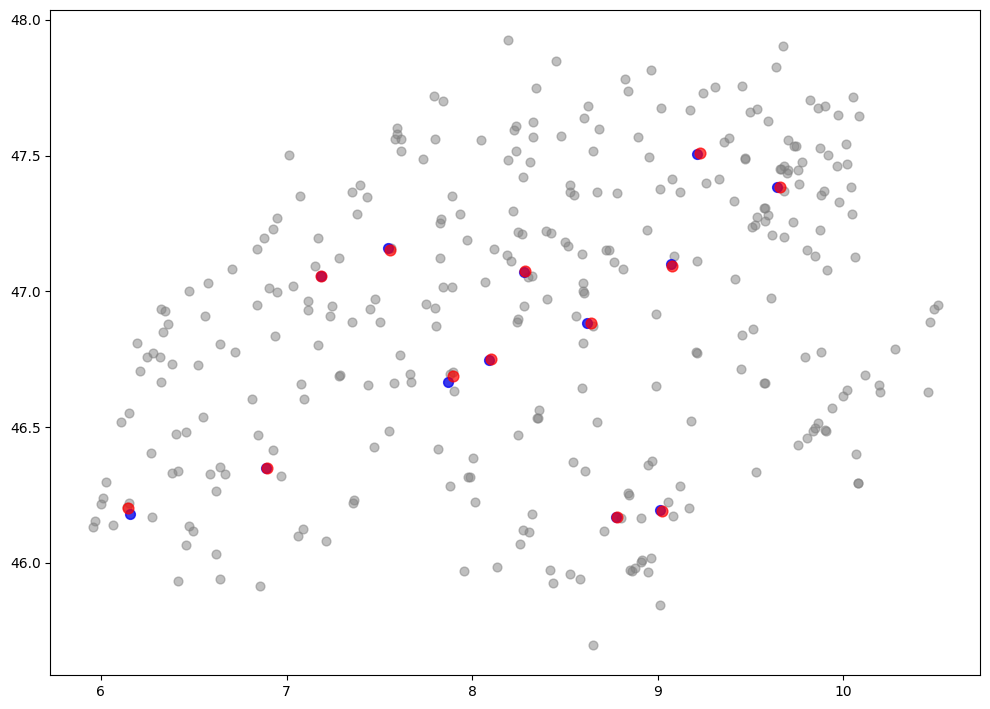

In [12]:
match_geometries = [geom for geom in matches_df['turbidity_geometry']]
matches_gdf = gpd.GeoDataFrame(matches_df, geometry=match_geometries, crs="EPSG:4326")

# Plot the matches
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all gauging stations in grey
gauging_stations_wgs84.plot(ax=ax, color='grey', markersize=40, alpha=0.5, label='All Gauging Stations')

# Plot matched gauging stations in blue
matched_gauge_ids = matches_df['gauge_id'].unique()
matched_gauges = gauging_stations_wgs84[gauging_stations_wgs84['gauge_id'].isin(matched_gauge_ids)]
matched_gauges.plot(ax=ax, color='blue', markersize=50, alpha=0.7, label='Matched Gauging Stations')

# Plot turbidity stations in red
matches_gdf.plot(ax=ax, color='red', markersize=60, alpha=0.7, label='Turbidity Stations')

# Connect matched pairs with lines
for _, row in matches_df.iterrows():
    turb_geom = row['turbidity_geometry']
    gauge_geom = row['gauge_geometry']

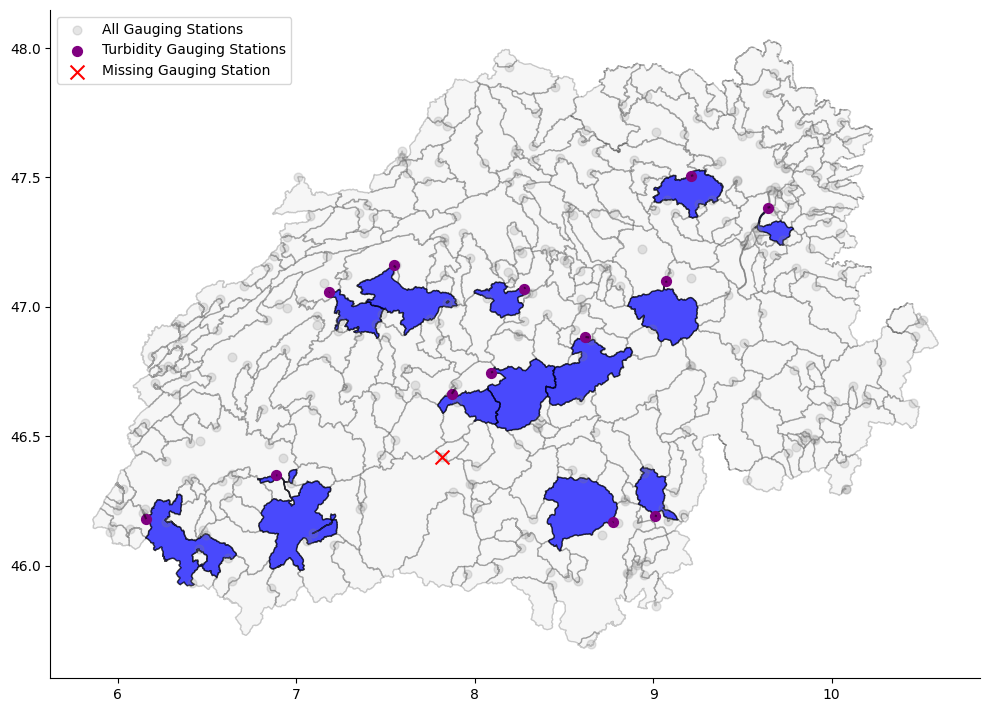

In [35]:
path_to_sub_catchments = "/Users/cooper/Desktop/CAMELS-CH/data/catchment_delineations/CAMELS_CH_sub_catchments_4326.shp"

sub_catchments = gpd.read_file(path_to_sub_catchments)

basins_with_gauging_stations = sub_catchments[sub_catchments['gauge_id'].isin(matched_gauge_ids)]

"""
river                               Massa
city                              Blatten
latitude                        46.420581
longitude                        7.819293
geometry     POINT (7.8192935 46.4205806)

This point is missing
"""

# Create a GeoDataFrame for the missing gauging stations
massa_missing = gpd.GeoDataFrame(
    {
        'river': ['Massa'],
        'city': ['Blatten'],
        'latitude': [46.420581],
        'longitude': [7.819293],
        'geometry': [Point(7.819293, 46.420581)]
    },
    crs="EPSG:4326"
)




# Plot with matplotlib
fig, ax = plt.subplots(figsize=(12, 10))
# Plot all sub-catchments in light grey
sub_catchments.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.2)
# Plot basins with gauging stations in blue
basins_with_gauging_stations.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7)
# Plot all gauging stations in grey
gauging_stations_wgs84.plot(ax=ax, color='grey', markersize=40, alpha=0.2, label='All Gauging Stations')
# Plot matched gauging stations in blue
matched_gauges.plot(ax=ax, color='purple', markersize=50, alpha=1, label='Turbidity Gauging Stations')
# Plot Massa missing gauging station in red withv an X
massa_missing.plot(ax=ax, color='red', markersize=100, marker='x', label='Missing Gauging Station')
for _, row in matches_df.iterrows():
    turb_geom = row['turbidity_geometry']
    gauge_geom = row['gauge_geometry']
    ax.plot([turb_geom.x, gauge_geom.x], [turb_geom.y, gauge_geom.y], color='black', linestyle='--', alpha=0.5)

sns.despine()
plt.legend()
plt.show()

In [23]:
# Save the matched gauging stations to shapefile, based on the matched gauge IDs
matched_gauging_stations = gauging_stations_wgs84[gauging_stations_wgs84['gauge_id'].isin(matched_gauge_ids)]

matched_gauging_stations.to_file(f"{path_to_data_folder}/matched_gauging_stations.shp")

# Save the corresponding basins to shapefile
basins_with_gauging_stations.to_file(f"{path_to_data_folder}/matched_basin_boundaries.shp")

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_44144/4216846534.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  matched_gauging_stations.to_file(f"{path_to_data_folder}/matched_gauging_stations.shp")
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'clean_water_body' to 'clean_wate'
  ogr_write(
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 704285151.376000047 of field Shape_Area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 555157142.582999945 of field Shape_Area of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/Users/cooper/Desk